In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
import numpy as np
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#*DEFINED* *FUNCTIONS*

---



In [4]:

# ======================= Cross validation for performance analysis.=========================== 
def CV(model,X,y):
  scoring = {'acc': 'accuracy',
           'AUC':'roc_auc',
            'f1':'f1'
           }
  scores = cross_validate(model, X, y, scoring=scoring,
                          cv=5, return_train_score=True)
  score_df=pd.DataFrame.from_dict(scores)
  print("\nScores for 5 folds:")
  print(score_df)
  return 

In [5]:
#============================== K Nearest Neighbor Classifier ===========================================================

from sklearn.neighbors import KNeighborsClassifier
def KNN(x_train, y_train,x_test):
  knn=KNeighborsClassifier()
  neigh = knn.fit(x_train, y_train)
  y_pred=neigh.predict(x_test)
  return y_pred

In [6]:
#============================== Decision Tree Classifier===========================================================

from sklearn import tree
from sklearn.metrics import accuracy_score
def DT(X_train,y_train,X_test):
  clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  return y_pred

In [7]:
# ================================ XG boost ===========================================
import xgboost as xgb
from sklearn.metrics import mean_squared_error
def XG(X_train,y_train,X_test):

  parameters = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 1.0],
        'max_depth': [3, 4, 5]
        }
  model = GridSearchCV(xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error'),
                    parameters,
                    )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return y_pred,model
                                                
  
  


In [8]:
# ================================ Random Forest ===========================================

from sklearn.ensemble import RandomForestClassifier
def RF(X_train,y_train,X_test):
  param_grid = { 
    'n_estimators': [100,200, 300,400],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10, 20, 30, 40, 50],
    'criterion' :['gini', 'entropy']
  }
  rfc=RandomForestClassifier(random_state=42)
  clf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  return y_pred,clf

In [9]:
# ================================ Naive Bayes ===========================================

from sklearn.naive_bayes import GaussianNB
def GNB(X_train,y_train,X_test):
  params = {'var_smoothing': [0.01, 0.1, 0.5, 1.0],
         }
  rfc = GaussianNB()
  clf = GridSearchCV(estimator=rfc, param_grid=params, cv= 5)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  return y_pred,clf


In [10]:
# ================================ Adaboost ===========================================
from sklearn.ensemble import AdaBoostClassifier
def ADB(X_train,y_train,X_test):

  params= {             
              "n_estimators": [100,200, 300,400],
              "learning_rate": [0.01, 0.1, 0.5]
             }
  rfc= AdaBoostClassifier()
  clf = GridSearchCV(estimator=rfc, param_grid=params, cv= 5)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  return y_pred,clf

In [11]:
from sklearn.ensemble import BaggingClassifier 
def bagging(X_train,y_train,X_test):
  params={
      "n_estimators": [100,200, 300,400]
  }
  rfc= BaggingClassifier() 
  clf = GridSearchCV(estimator=rfc, param_grid=params, cv= 5)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  return y_pred,clf

<h4> Model hyperparameter tuning using gridsearchcv for finding Best parameters for each model.</h4>

In [12]:
def BestHyperParams_GridSearchCV(model,param_grid,X_train,Y_train):
  # print("Grid Search for hyper parameter tunning.")
  grid = GridSearchCV(model,param_grid,refit = True, verbose=2,cv=5, scoring='accuracy')
  grid.fit(X_train,Y_train)
  return grid.best_params_

#***DATA  PRE PROCESSING ***

---



In [13]:
#path for dataset
data=pd.read_csv("/content/drive/MyDrive/MLBA Project/diabetes.csv")

In [14]:
# =========================== describing data  =======================================
# print(data)
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<h2> Data Competency Assessment</h2>
<ul>
<li>Checking Null values.</li>
<li>Finding correlation between the different features.</li>
<li>Finding Best features for the best model performance.</li>
</ul>

Is there any Null value?  False


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


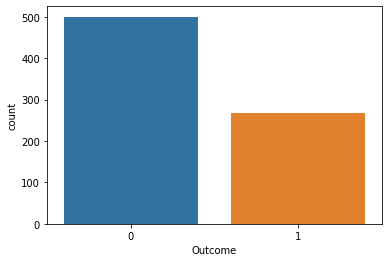

In [15]:
# =========================== Finding null value =======================================
# data.fillna(data.mean())
print("Is there any Null value? ",data.isnull().any().any())
# =========================== plotting class distribution =======================================
sns.countplot(data['Outcome'])

<h3> Observations from the above Countplot.</h3>
<ul>
<li> There is the problem of class imbalancy (using oversampling techniques to handel this problem). </li>
</ul>

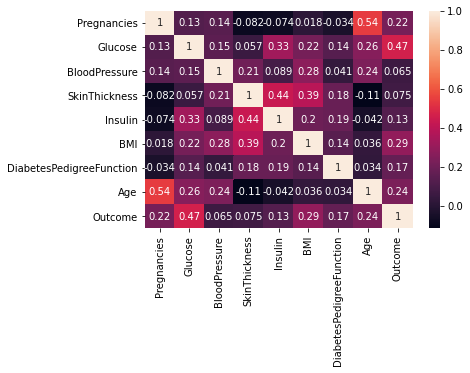

In [16]:
# =========================== Cheacking Corrilation Between the different Features =======================================
# sns.heatmap(data,annot=True, fmt="g", cmap='viridis')
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

<h3> Observations from the above heatmap.</h3>
<ul> 
<li>We found no two features are highly correlated to each other so all the features are useful to predict the outcome.
<li> Features like glucose is heighly correlated to the outcome. So it'll be heighly useful for predicting outcome.</li>
</ul>

<h3>

<h4> Dataset Scaling for feature standerization.</h4>

In [17]:
# =========================== Scaling data  =======================================
scaler = StandardScaler()
# data_train=data.drop(['Outcome'],axis=1)
scaled_data=scaler.fit_transform(data.drop(['Outcome'],axis=1))
X= pd.DataFrame(scaled_data, index=data.index, columns=list(data.columns)[:-1])
Y=data['Outcome']
print(X)

     Pregnancies   Glucose  ...  DiabetesPedigreeFunction       Age
0       0.639947  0.848324  ...                  0.468492  1.425995
1      -0.844885 -1.123396  ...                 -0.365061 -0.190672
2       1.233880  1.943724  ...                  0.604397 -0.105584
3      -0.844885 -0.998208  ...                 -0.920763 -1.041549
4      -1.141852  0.504055  ...                  5.484909 -0.020496
..           ...       ...  ...                       ...       ...
763     1.827813 -0.622642  ...                 -0.908682  2.532136
764    -0.547919  0.034598  ...                 -0.398282 -0.531023
765     0.342981  0.003301  ...                 -0.685193 -0.275760
766    -0.844885  0.159787  ...                 -0.371101  1.170732
767    -0.844885 -0.873019  ...                 -0.473785 -0.871374

[768 rows x 8 columns]


<h4> Dataset Oversampling for handeling class imbalance problem.</h4>

In [18]:
  oversample = RandomOverSampler(sampling_strategy='minority',random_state=48)
  # fit and apply the transform
  X_over, y_over = oversample.fit_resample(X, Y)
  # summarize class distribution
  print(Counter(y_over))

Counter({1: 500, 0: 500})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#***EVALUATING MODELS***

---



<h3> GridSearchCV for finding Best Hyperparameters for different models.</h3>


In [19]:
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
model=SVC()
# print("Best hyperparameters",BestHyperParams_GridSearchCV(model,param_grid,X,Y))

In [20]:
# ==========================spliting data into 70:30 train test data ==============================
x_train, x_test, y_train, y_test = train_test_split(X, Y ,test_size=0.3, random_state=42)

In [21]:
#============================== MultiLayerPerceptron Classifier===========================================================
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, solver="sgd",max_iter=700).fit(x_train, y_train)
pred_MLP=clf.predict(x_test)
print(classification_report(y_test, pred_MLP, target_names=["0","1"]))


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       151
           1       0.62      0.61      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231



In [22]:
# =========== Evaluating ML models = KNN,DT and deep learning model = MLP ,ensemble model XGboosting on 30 % test data ============
print("======================== For KNN")
CV(KNeighborsClassifier(),x_train,y_train)
pred_KNN=KNN(x_train,y_train,x_test)
print(classification_report(y_test, pred_KNN, target_names=["0","1"]))

print("========================= For Decision Tree")
CV(tree.DecisionTreeClassifier(),x_train,y_train)
pred_DT=DT(x_train,y_train,x_test)
print(classification_report(y_test, pred_DT, target_names=["0","1"]))

print("========================== For XG boosting")
pred_XG,model=XG(x_train,y_train,x_test)
CV(model,x_train,y_train)
print(classification_report(y_test, pred_XG, target_names=["0","1"]))

print("=========================== For MLP")
CV(clf,x_train,y_train)
print(classification_report(y_test, pred_MLP, target_names=["0","1"]))


======================== For KNN

Scores for 5 folds:
   fit_time  score_time  test_acc  ...  train_AUC   test_f1  train_f1
0  0.003158    0.011836  0.759259  ...   0.884624  0.648649  0.712727
1  0.002062    0.011459  0.787037  ...   0.900311  0.646154  0.724638
2  0.001995    0.008035  0.766355  ...   0.898799  0.626866  0.708029
3  0.001389    0.007887  0.766355  ...   0.915521  0.637681  0.754448
4  0.001412    0.007394  0.710280  ...   0.903250  0.575342  0.746377

[5 rows x 8 columns]
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       151
           1       0.56      0.51      0.54        80

    accuracy                           0.69       231
   macro avg       0.66      0.65      0.65       231
weighted avg       0.69      0.69      0.69       231

========================= For Decision Tree

Scores for 5 folds:
   fit_time  score_time  test_acc  ...  train_AUC   test_f1  train_f1
0  0.002962    0.002882  0.740741  ...    

In [ ]:
# =========== Evaluating ML models = Random Forest,Naive Bayes , Adaboost on 30 % test data ============

print("======================== For Adaboost")
pred_ADB,model=ADB(x_train,y_train,x_test)
CV(model,x_train,y_train)
print(classification_report(y_test, pred_ADB, target_names=["0","1"]))
print("======================== For Naive Bayes")
pred_NB,model=GNB(x_train,y_train,x_test)
CV(model,x_train,y_train)
print(classification_report(y_test, pred_NB, target_names=["0","1"]))
print("======================== For Bagging")
pred_bag,model=bagging(x_train,y_train,x_test)
CV(model,x_train,y_train)
print(classification_report(y_test, pred_bag, target_names=["0","1"]))


======================== For Adaboost

Scores for 5 folds:
    fit_time  score_time  test_acc  ...  train_AUC   test_f1  train_f1
0  21.785151    0.048244  0.796296  ...   0.919785  0.666667  0.743682
1  21.818772    0.075219  0.703704  ...   0.886045  0.515152  0.664093
2  21.949043    0.048084  0.803738  ...   0.913053  0.695652  0.735714
3  21.654802    0.026333  0.691589  ...   0.917064  0.459016  0.725926
4  21.520075    0.025876  0.757009  ...   0.906060  0.617647  0.695341

[5 rows x 8 columns]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       151
           1       0.64      0.64      0.64        80

    accuracy                           0.75       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.75      0.75      0.75       231

======================== For Naive Bayes

Scores for 5 folds:
   fit_time  score_time  test_acc  ...  train_AUC   test_f1  train_f1
0  0.048265    0.003174  0.787037 